## Analyze A/B Test Results



<a id='intro'></a>
### Introduction

The A/B test will be run for an e-commerce website to help them understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.




In [67]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Read in the dataset.

In [68]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


The number of unique users in the dataset.

In [70]:
df.user_id.nunique()

290584

The proportion of users converted.

In [71]:
df.converted.mean()*100

11.965919355605511

The number of times the `new_page` and `treatment` don't line up.

In [72]:
len(df.query('landing_page != "new_page" and group=="treatment"'))

1965

Do any of the rows have missing values?

In [73]:
df.info() # No missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. So correcting for that:


In [74]:
treatment = df.query('(group == "treatment" and landing_page == "new_page")==True')

In [75]:
control = df.query('(group == "control" and landing_page == "old_page")==True')


In [ ]:
df2 = pd.merge(control,treatment,how='outer') #Making a new dataframe with merged treatment and control queried tables

In [77]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1
3,936923,2017-01-10 15:20:49.083499,control,old_page,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [78]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 290584
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


How many unique **user_id**s are in **df2**?

In [79]:
df2.user_id.nunique()

290584

There is one **user_id** repeated in **df2**.

In [80]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
146212,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
146678,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


What is the row information for the repeat **user_id**? 

In [81]:
df2.iloc[146212]

user_id                             773192
timestamp       2017-01-09 05:37:58.781806
group                            treatment
landing_page                      new_page
converted                                0
Name: 146212, dtype: object

Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [82]:
df2.drop(df2.index[[146212]],inplace=True)

In [83]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [84]:
df2.converted.mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [85]:
control_conv=df2.query('group=="control"')['converted'].mean()
control_conv

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [86]:
treatment_conv=df2.query('group=="treatment"')['converted'].mean()
treatment_conv

0.11880806551510564

What is the probability that an individual received the new page?

In [87]:
len(df.query('landing_page=="new_page"'))/len(df)

0.5

In [88]:
pdiff_actual=treatment_conv-control_conv
pdiff_actual


-0.0015782389853555567

Is there evidence that one page leads to more conversions?

**The probability that a treatment page leads to conversion is 0.118 ~ 0.12 and the probability that a control page leads to conversion is also 0.12. Therefore there is enough evidence if either of them causes more conversions or not. **

### A/B Test

Notice that because of the time stamp associated with each event, we can technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  

For now, considering we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should the null and alternative hypotheses be?  

**Null Hypothesis:** The new version is no better, or even worse, than the old version
                            **$p_{new}$**  ≤ **$p_{old}$**


**Alternative Hypothesis:** The new version is better than the old version
                            **$p_{new}$**  > **$p_{old}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming they are equal to the **converted** rate in daya regardless of the page. <br><br>

Using a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Using the cells below to provide the necessary parts of this simulation.  

a. What is the **convert rate** for $p_{new}$ under the null? 

In [89]:
p_new=len(df2.query('converted == 1'))/len(df2)
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [90]:
p_old=len(df2.query('converted == 1'))/len(df2)
p_old

0.11959708724499628

c. What is $n_{new}$?

In [91]:
n_new=len(df2.query('landing_page=="new_page"'))
n_new

145310

d. What is $n_{old}$?

In [92]:
n_old=len(df2.query('landing_page=="old_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [93]:
new_page_converted=np.random.binomial(1,p_new,n_new)
new_page_converted.mean()

0.11955818594728511

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [94]:
old_page_converted=np.random.binomial(1,p_old,n_old)
old_page_converted.mean()

0.11874113743684349

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

obs_diff=new_page_converted.mean() - old_page_converted.mean()
obs_diff

In [95]:
obs_diff=new_page_converted.mean() - old_page_converted.mean()
obs_diff

0.0008170485104416203

Again the difference between the two converted rates show old page to have a high conversion rate as compared to the the new page. But then the difference is very small.

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process 

In [96]:
p_diffs=[]
random.seed(42)
for _ in range(0,10000):
    new_converted=np.random.binomial(1,p_new,n_new)
    old_converted=np.random.binomial(1,p_old,n_old)
    p_diffs.append(new_converted.mean()-old_converted.mean())

i. Plot a histogram of the **p_diffs**. 

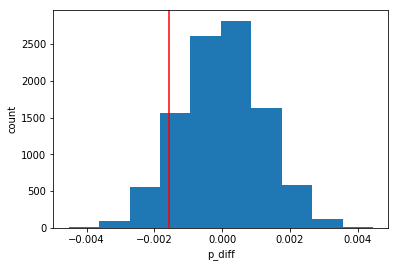

In [97]:
plt.hist(p_diffs)
plt.xlabel('p_diff')
plt.ylabel('count')
plt.axvline(pdiff_actual,color='red')

The plot shows a normal distribution of differences in conversion rate centered at 0. The red line shows the difference calculated from the actual dataset and shows that chances of accepting null are higher since it falls near the null hypothesized value.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [98]:
p_diffs=np.array(p_diffs)

In [99]:
p_diffs.mean()

-1.0951317679616226e-06

The difference calculated from our null is also close to zero. 

In [100]:
(p_diffs > pdiff_actual).mean() #pdiff_actual = -0.0015

0.90249999999999997

**This is the p-value (0.90) and is grater than the alpha level  of 0.05 therefore we fail to reject the null hypothesis which states that the new page is no better or even worse than the old page.So according to our test the new page is not better than the old page**

l. We could also use a built-in to achieve similar results.  

In [101]:
import statsmodels.api as sm

convert_old = len(df2.query('group=="control" and converted==1'))
convert_new = len(df2.query('group=="treatment" and converted==1'))
n_old = len(df2.query('group=="control"'))
n_new = len(df2.query('group=="treatment"'))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [102]:
 z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new],alternative='smaller', prop_var=False)
z_score, p_value 

(1.3109241984234394, 0.90505831275902449)

>proportions_ztest(count, nobs, value=None, alternative='smaller', prop_var=False) 
alternative (string in ['two-sided', 'smaller', 'larger']) – The alternative hypothesis can be either two-sided or one of the one- sided tests, smaller means that the alternative hypothesis is prop < value and larger means prop > value. In the two sample test, smaller means that the alternative hypothesis is p1 < p2 and larger means p1 > p2 where p1 is the proportion of the first sample and p2 of the second one.

In [103]:
from scipy.stats import norm

In [104]:
norm.ppf(1-(0.05/2)) # Critical value for z score with a confidence interval of 95%

1.959963984540054

**The findings are consistent with our conducted test. The z-score is less than the critical value of (1.96 calculated through norm.ppf function) so we fail to reject our null hypothesis. The p values calculated in part j and k are consistent i.e 0.9 so we fail to reject our null hypothesis.**


A regression approach

`1.` In this final part, we will see that the result we acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, we perform logistic regression

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Adding an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [105]:
df2['intercept']=1
df2[['control','treatment']]=pd.get_dummies(df2.group)

In [106]:
df2.drop('control',axis=1,inplace=True)

In [107]:
df2.rename(columns={'treatment':'ab_page'},inplace=True)

In [108]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0


Fitting the model using to predict whether or not an individual converts.

In [54]:
import statsmodels.api as sm

In [55]:
df2['intercept'] = 1
logit_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
res= logit_mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Jun 2018   Pseudo R-squ.:               8.077e-06
Time:                        08:56:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p value is 0.19

In [53]:
np.exp(-0.0150)

0.98511193960306265

**The model is constructed using the Logistic Regression technique. The interpretation of the results is such that there is 0.98 times more chance of conversion if the treatment page is received by the individual.**

**The p-value differs from the one in previous parts because we were doing a one tailed test in previous parts i.e. if conversion is greater for one page or not whereas the nature of regression test is such that we check if either of the condition causes any significant effect on the conversion and is therefore two-tailed test.**

**Inclusion of other factors into the model might cause multicollinearity.**

Now along with testing if the conversion rate changes for different pages, adding an effect based on which country a user lives. 


In [62]:
df_con = pd.read_csv('countries.csv')
df_con.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there are significant effects on conversion.

In [63]:
d=df2.merge(df_con,how='left')

In [64]:
d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 290583
Data columns (total 9 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
ab_page         290584 non-null uint8
ab_page         290584 non-null uint8
country         290584 non-null object
dtypes: int64(3), object(4), uint8(2)
memory usage: 18.3+ MB


In [65]:
d[['UK','US','CA']]=pd.get_dummies(d.country)

Dropping one column from the model to maintain the matrix rank.

In [58]:
d['intercept'] = 1
logit_mod = sm.Logit(d['converted'],d[['intercept','ab_page','UK','US']])
res= logit_mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Jun 2018   Pseudo R-squ.:               2.323e-05
Time:                        06:40:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK            -0.0408      0.027     -1.516      0.130      -0.093       0.012
US             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [62]:
UK,US=np.exp(-.0408),np.exp(0.0099)
UK,US


(0.96002111497165088, 1.0099491671175422)

In [60]:
np.exp(-0.0149)

0.9852104557227469

The interpreted results show high correlation of conversion with being in US with a one to one correspondence. Also 0.98 times more likely of conversion if the landed page is treatment, as per these findings.

In [66]:
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
df2.timestamp.max() - df2.timestamp.min()

Timedelta('21 days 23:59:49.081927')

Also, the test was run for a very short duration of 21 days. This might be the reason why we were not able to find significant difference between the p_old and p_new.